In [ ]:
# other stuff
# from EK_modified import edmonds_karp
#
# import networkx as nx
#
# G = nx.DiGraph()
# G.add_edge("x", "a", capacity=3.0)
# G.add_edge("x", "b", capacity=1.0)
# G.add_edge("a", "c", capacity=3.0)
# G.add_edge("b", "c", capacity=5.0)
# G.add_edge("b", "d", capacity=4.0)
# G.add_edge("d", "e", capacity=2.0)
# G.add_edge("c", "y", capacity=2.0)
# G.add_edge("e", "y", capacity=3.0)
#
# R = edmonds_karp(G, "x", "y")
# flow_value = nx.maximum_flow_value(G, "x", "y")
# print(flow_value)
#
# flow_value == R.graph["flow_value"]
#
# print(flow_value)


In [43]:
# importing libraries

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import copy
import matplotlib.pyplot as plt

In [44]:
# importing data & viewing
raw_data = pd.read_csv('./data/data_v1.csv')
print("Shape:", raw_data.shape)
print(raw_data.head())


Shape: (17, 7)
   Arbitrator_id  Arbitrator_seniority Arbitrator_background  \
0              1                    18     Quantity Surveyor   
1              1                    18     Quantity Surveyor   
2              1                    18     Quantity Surveyor   
3              1                    18     Quantity Surveyor   
4              2                    18              Engineer   

   Arbitrator_total_accepted_cases          Case_nature  Case_dispute_amount  \
0                                1    Construction_Case                12500   
1                                1    Construction_Case               100000   
2                                1    Construction_Case                72080   
3                                1  Building Management                50000   
4                                5    Construction_Case                 4500   

   Case_accepted  
0              1  
1              0  
2              0  
3              0  
4              1  


In [45]:
# onehot enocoding categorical data
mod1_data = raw_data.astype({'Arbitrator_id': 'object'})
mod2_data = mod1_data.copy()
for col in mod1_data.columns:
    if mod1_data.dtypes[col] == "object":
        mod1_data[col] = LabelEncoder().fit_transform(mod1_data[col])
        n = np.max(mod1_data[col])
        tempCol = torch.nn.functional.one_hot(torch.from_numpy(mod1_data[col].to_numpy()), int(n) + 1)
        tempCol = torch.transpose(tempCol, 0, 1).tolist()
        mod2_data.drop(columns=col, inplace=True)

        for i in range(len(tempCol)):
            mod2_data[col+"_"+str(i)] = tempCol[i]
            
# print(raw_data.head())
# print(mod1_data.head())
mod2_data

,Arbitrator_seniority,Arbitrator_total_accepted_cases,Case_dispute_amount,Case_accepted,Arbitrator_id_0,Arbitrator_id_1,Arbitrator_id_2,Arbitrator_id_3,Arbitrator_id_4,Arbitrator_id_5,Arbitrator_id_6,Arbitrator_background_0,Arbitrator_background_1,Arbitrator_background_2,Arbitrator_background_3,Case_nature_0,Case_nature_1
0,18,1,12500,1,1,0,0,0,0,0,0,0,0,0,1,0,1
1,18,1,100000,0,1,0,0,0,0,0,0,0,0,0,1,0,1
2,18,1,72080,0,1,0,0,0,0,0,0,0,0,0,1,0,1
3,18,1,50000,0,1,0,0,0,0,0,0,0,0,0,1,1,0
4,18,5,4500,1,0,1,0,0,0,0,0,0,1,0,0,0,1
5,18,5,4500,1,0,1,0,0,0,0,0,0,1,0,0,0,1
6,18,5,12500,1,0,1,0,0,0,0,0,0,1,0,0,0,1
7,18,5,40000,1,0,1,0,0,0,0,0,0,1,0,0,0,1
8,18,5,4500,1,0,1,0,0,0,0,0,0,1,0,0,1,0
9,18,5,49066,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [46]:
# splitting into train:validation:test
data_split = [0.6, 0.2, 0.2]
N = mod2_data.shape[0]
train_size = int(N*data_split[0])
valid_size = int(N*data_split[1])

train = mod2_data[:train_size]
valid = mod2_data[train_size: train_size + valid_size]
test = mod2_data[train_size+valid_size:]

print("train:", train.shape)
print("valid:", valid.shape)
print("test:", test.shape)

Ytrain = train.loc[:, 'Case_accepted']
Xtrain = train.drop(columns='Case_accepted')

Yvalid = valid.loc[:, 'Case_accepted']
Xvalid = valid.drop(columns='Case_accepted')

Ytest = test.loc[:, 'Case_accepted']
Xtest = test.drop(columns='Case_accepted')

train: (10, 17)
valid: (3, 17)
test: (4, 17)


In [47]:
# converting to tensors
Xtrain = torch.from_numpy(Xtrain.to_numpy())
Ytrain = torch.from_numpy(Ytrain.to_numpy())

Xvalid = torch.from_numpy(Xvalid.to_numpy())
Yvalid = torch.from_numpy(Yvalid.to_numpy())

Xtest = torch.from_numpy(Xtest.to_numpy())
Ytest = torch.from_numpy(Ytest.to_numpy())

In [48]:
# defining dataset 
class ArbitratorDataset(Dataset):
    def __init__(self, X, Y):
        self.x = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [49]:
# creating train and valid dataset
train_ds = ArbitratorDataset(Xtrain, Ytrain)
valid_ds = ArbitratorDataset(Xvalid, Yvalid)
test_ds = ArbitratorDataset(Xtest, Ytest)

# creating dataloaders
batch_size = 2
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=True) 
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, drop_last=True) 
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True) 


In [50]:
# defining model

class CaseArbitrationModel(nn.Module):
    def __init__(self, inp_size):
        super().__init__()  
        self.bn0 = nn.BatchNorm1d(16)
        
        self.lin1 = nn.Linear(inp_size, 100)
        self.bn1 = nn.BatchNorm1d(100)
        
        self.lin2 = nn.Linear(100, 50)
        self.bn2 = nn.BatchNorm1d(50)
        
        self.lin3 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
        self.drops = nn.Dropout(0.3)

    def forward(self, x):
        x = self.bn0(x)
        
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn1(x)
        
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn2(x)
        
        x = self.lin3(x)
        x = self.sigmoid(x)
        
        return x

model = CaseArbitrationModel(16)

In [51]:
def test(model, testloader, device, return_softmax=False):
    all_preds = torch.LongTensor().to(device)
    all_targets = torch.LongTensor().to(device)

    if return_softmax:
        all_outs = torch.FloatTensor().to(device)

    model.to(device)

    with torch.no_grad():
        for data in testloader:

            inputs, labels = data[0], data[1]

            inputs = inputs.to(device).float()      
            labels = labels.view(-1, 1)
            labels = labels.to(device).float()

            outputs = model(inputs)

            if return_softmax:
                all_outs = torch.cat((all_outs, outputs.data), 0) 

            if len(outputs.data) == 0:
                continue
            
            pred = torch.round(outputs)
#             print("outs:", outputs)
#             print("predicted:", pred)
#             print("labels:", labels)
#             print("~~~~~~~~~~~~~~~~")
            all_preds = torch.cat((all_preds, pred), 0)
            all_targets = torch.cat((all_targets, labels), 0) 
#     print("------------------------")
    return all_preds, all_targets

In [59]:
# defining training process
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

all_loss = []
all_valid_acc = []
all_train_acc = []

best_acc = 0

epoch = 0

loss_fn = nn.BCELoss()
best_model_weights = None

while epoch < 50:
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data[0], data[1]

        inputs = inputs.to(device).float()      
        labels = labels.view(2, 1)
        labels = labels.to(device).float()
        
        #zero the param gradients
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = model(inputs)
        
#         print(outputs)
#         print(labels)

        loss = loss_fn(outputs, labels)
        
        loss.sum().backward()
        optimizer.step()
        
        #print statistics - have to get more of these
        running_loss += loss.sum().item()
        all_loss.append(loss.sum().item())
        if (i) % 4 == 0:
            #every 4 batch print - loss, training acc, validation acc
            train_pred, train_target = test(model, train_dl, device)
            valid_pred, valid_target = test(model, valid_dl, device)
            train_acc = accuracy_score(train_target.cpu(), train_pred.cpu())
            valid_acc = accuracy_score(valid_target.cpu(), valid_pred.cpu()) 
            
            all_train_acc.append(train_acc)
            all_valid_acc.append(valid_acc)
            
            print('Running Training Loss:', running_loss)
            print('Training Accuracy:', train_acc)
            print('Valid Accuracy:', valid_acc)
            if valid_acc > best_acc:
                best_acc = valid_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            model.load_state_dict(best_model_weights)
            print('################################')
            running_loss = 0.0
        

    epoch += 1   
print('Finished Training')

Running Training Loss: 0.3771096467971802
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 2.6054394245147705
Training Accuracy: 0.8
Valid Accuracy: 1.0
################################
Running Training Loss: 0.4498811364173889
Training Accuracy: 0.7
Valid Accuracy: 0.5
################################
Running Training Loss: 2.4871963560581207
Training Accuracy: 0.7
Valid Accuracy: 0.5
################################
Running Training Loss: 0.3643839359283447
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 2.520662844181061
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 0.2851157486438751
Training Accuracy: 0.7
Valid Accuracy: 0.5
################################
Running Training Loss: 2.40189129114151
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 0.3860592544078827
Training Accuracy

Running Training Loss: 0.23355308175086975
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 2.5909574031829834
Training Accuracy: 0.8
Valid Accuracy: 1.0
################################
Running Training Loss: 0.2877722978591919
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 2.465603768825531
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 0.31791606545448303
Training Accuracy: 0.8
Valid Accuracy: 1.0
################################
Running Training Loss: 2.390296459197998
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 0.2788669466972351
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 2.5852463245391846
Training Accuracy: 0.8
Valid Accuracy: 0.5
################################
Running Training Loss: 0.2145417034626007
Training Accur

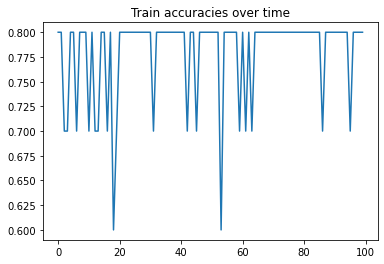

In [60]:
# plotting training accuracy over time

x = np.arange(len(all_train_acc))
plt.plot(x, all_train_acc)
plt.title("Train accuracies over time")
plt.show()

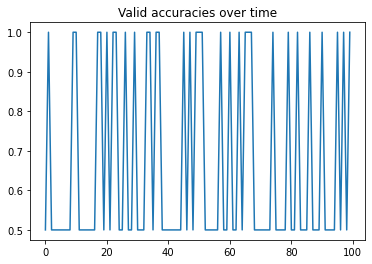

In [61]:
# plotting validation accuracy over time

x = np.arange(len(all_valid_acc))
plt.plot(x, all_valid_acc)
plt.title("Valid accuracies over time")
plt.show()

In [62]:
# testing with test dl

test_pred, test_target = test(model, test_dl, device)
test_acc = accuracy_score(test_target.cpu(), test_pred.cpu())
print("test accuracy:", test_acc)

test accuracy: 0.75
